<a href="https://colab.research.google.com/github/yoonyoung27/prac_class/blob/main/Team_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 나눔 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,503 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and d

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [123]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', encoding='cp949')  # CSV파일에 한글로 된 내용이 있는 경우
train.head()

num      date_time  전력사용량(kWh)  기온(°C)  ...  강수량(mm)  일조(hr)  비전기냉방설비운영  태양광보유
0    1  2020-06-01 00    8179.056    17.6  ...      0.8     0.0        0.0    0.0
1    1  2020-06-01 01    8135.640    17.7  ...      0.3     0.0        0.0    0.0
2    1  2020-06-01 02    8107.128    17.5  ...      0.0     0.0        0.0    0.0
3    1  2020-06-01 03    8048.808    17.1  ...      0.0     0.0        0.0    0.0
4    1  2020-06-01 04    8043.624    17.0  ...      0.0     0.0        0.0    0.0

[5 rows x 10 columns]

* num : 건물번호
* date_time : 시간

In [124]:
train.columns = ['num','datetime','usage','temperature','windspeed','humidity','precipitation','sunshine','nelec_cool_flag','solar_flag']

In [125]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [136]:
eda = train.copy()

In [137]:
eda['datetime'] = pd.to_datetime(eda['datetime'])
eda['hour'] = eda['datetime'].dt.hour
eda['weekday'] = eda['datetime'].dt.weekday
eda['date'] = eda['datetime'].dt.date
eda['day'] = eda['datetime'].dt.day
eda['month'] = eda['datetime'].dt.month
eda['weekend'] = eda['weekday'].isin([5,6]).astype(int)

In [138]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   num              122400 non-null  int64         
 1   datetime         122400 non-null  datetime64[ns]
 2   usage            122400 non-null  float64       
 3   temperature      122400 non-null  float64       
 4   windspeed        122400 non-null  float64       
 5   humidity         122400 non-null  float64       
 6   precipitation    122400 non-null  float64       
 7   sunshine         122400 non-null  float64       
 8   nelec_cool_flag  122400 non-null  float64       
 9   solar_flag       122400 non-null  float64       
 10  hour             122400 non-null  int64         
 11  weekday          122400 non-null  int64         
 12  date             122400 non-null  object        
 13  day              122400 non-null  int64         
 14  month            122

In [139]:
eda.set_index('datetime', inplace=True)
eda.head()

num     usage  temperature  ...  day  month  weekend
datetime                                         ...                     
2020-06-01 00:00:00    1  8179.056         17.6  ...    1      6        0
2020-06-01 01:00:00    1  8135.640         17.7  ...    1      6        0
2020-06-01 02:00:00    1  8107.128         17.5  ...    1      6        0
2020-06-01 03:00:00    1  8048.808         17.1  ...    1      6        0
2020-06-01 04:00:00    1  8043.624         17.0  ...    1      6        0

[5 rows x 15 columns]

In [140]:
eda_num1 = eda[eda['num']==1]
eda_num1.asfreq('H')

num     usage  temperature  ...  day  month  weekend
datetime                                         ...                     
2020-06-01 00:00:00    1  8179.056         17.6  ...    1      6        0
2020-06-01 01:00:00    1  8135.640         17.7  ...    1      6        0
2020-06-01 02:00:00    1  8107.128         17.5  ...    1      6        0
2020-06-01 03:00:00    1  8048.808         17.1  ...    1      6        0
2020-06-01 04:00:00    1  8043.624         17.0  ...    1      6        0
...                  ...       ...          ...  ...  ...    ...      ...
2020-08-24 19:00:00    1  8714.952         29.4  ...   24      8        0
2020-08-24 20:00:00    1  8740.224         28.7  ...   24      8        0
2020-08-24 21:00:00    1  8730.504         28.3  ...   24      8        0
2020-08-24 22:00:00    1  8725.968         28.3  ...   24      8        0
2020-08-24 23:00:00    1  8705.232         28.1  ...   24      8        0

[2040 rows x 15 columns]

In [141]:
eda_num1.asfreq('H').isna().sum()

num                0
usage              0
temperature        0
windspeed          0
humidity           0
precipitation      0
sunshine           0
nelec_cool_flag    0
solar_flag         0
hour               0
weekday            0
date               0
day                0
month              0
weekend            0
dtype: int64

In [142]:
eda['num'].value_counts()

60    2040
59    2040
28    2040
27    2040
26    2040
25    2040
24    2040
23    2040
22    2040
21    2040
20    2040
19    2040
18    2040
17    2040
16    2040
15    2040
14    2040
13    2040
12    2040
11    2040
10    2040
9     2040
8     2040
7     2040
6     2040
5     2040
4     2040
3     2040
2     2040
29    2040
30    2040
31    2040
46    2040
58    2040
57    2040
56    2040
55    2040
54    2040
53    2040
52    2040
51    2040
50    2040
49    2040
48    2040
47    2040
45    2040
32    2040
44    2040
43    2040
42    2040
41    2040
40    2040
39    2040
38    2040
37    2040
36    2040
35    2040
34    2040
33    2040
1     2040
Name: num, dtype: int64

In [143]:
eda.reset_index(inplace=True)

In [144]:
print(len(eda[eda['sunshine']==0.0]), len(eda[eda['nelec_cool_flag']==0.0]), len(eda[eda['solar_flag']==0.0]))

85394 38760 63240


In [145]:
eda['sunshine'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: sunshine, dtype: int64

In [146]:
non_ele = train.groupby('num')['nelec_cool_flag'].unique()
non_ele

num
1     [0.0]
2     [1.0]
3     [1.0]
4     [1.0]
5     [1.0]
6     [0.0]
7     [1.0]
8     [1.0]
9     [0.0]
10    [1.0]
11    [0.0]
12    [1.0]
13    [1.0]
14    [1.0]
15    [1.0]
16    [1.0]
17    [1.0]
18    [0.0]
19    [0.0]
20    [0.0]
21    [0.0]
22    [1.0]
23    [0.0]
24    [1.0]
25    [1.0]
26    [0.0]
27    [1.0]
28    [1.0]
29    [0.0]
30    [1.0]
31    [1.0]
32    [0.0]
33    [1.0]
34    [1.0]
35    [1.0]
36    [0.0]
37    [1.0]
38    [1.0]
39    [1.0]
40    [1.0]
41    [1.0]
42    [1.0]
43    [1.0]
44    [1.0]
45    [0.0]
46    [1.0]
47    [1.0]
48    [0.0]
49    [0.0]
50    [0.0]
51    [0.0]
52    [1.0]
53    [1.0]
54    [1.0]
55    [1.0]
56    [0.0]
57    [1.0]
58    [1.0]
59    [1.0]
60    [1.0]
Name: nelec_cool_flag, dtype: object

In [147]:
eda.groupby('num')['nelec_cool_flag'].mean().value_counts()

1.0    41
0.0    19
Name: nelec_cool_flag, dtype: int64

In [148]:
sun = eda.groupby('num')['solar_flag'].unique()
sun

num
1     [0.0]
2     [0.0]
3     [1.0]
4     [1.0]
5     [0.0]
6     [0.0]
7     [0.0]
8     [1.0]
9     [1.0]
10    [0.0]
11    [0.0]
12    [1.0]
13    [0.0]
14    [1.0]
15    [0.0]
16    [1.0]
17    [0.0]
18    [0.0]
19    [0.0]
20    [0.0]
21    [1.0]
22    [0.0]
23    [1.0]
24    [1.0]
25    [0.0]
26    [1.0]
27    [1.0]
28    [0.0]
29    [0.0]
30    [1.0]
31    [0.0]
32    [0.0]
33    [0.0]
34    [1.0]
35    [0.0]
36    [1.0]
37    [1.0]
38    [1.0]
39    [1.0]
40    [1.0]
41    [0.0]
42    [1.0]
43    [1.0]
44    [1.0]
45    [1.0]
46    [0.0]
47    [1.0]
48    [0.0]
49    [0.0]
50    [0.0]
51    [1.0]
52    [1.0]
53    [0.0]
54    [0.0]
55    [1.0]
56    [1.0]
57    [0.0]
58    [0.0]
59    [0.0]
60    [1.0]
Name: solar_flag, dtype: object

In [149]:
eda.groupby('num')['solar_flag'].mean().value_counts()

0.0    31
1.0    29
Name: solar_flag, dtype: int64

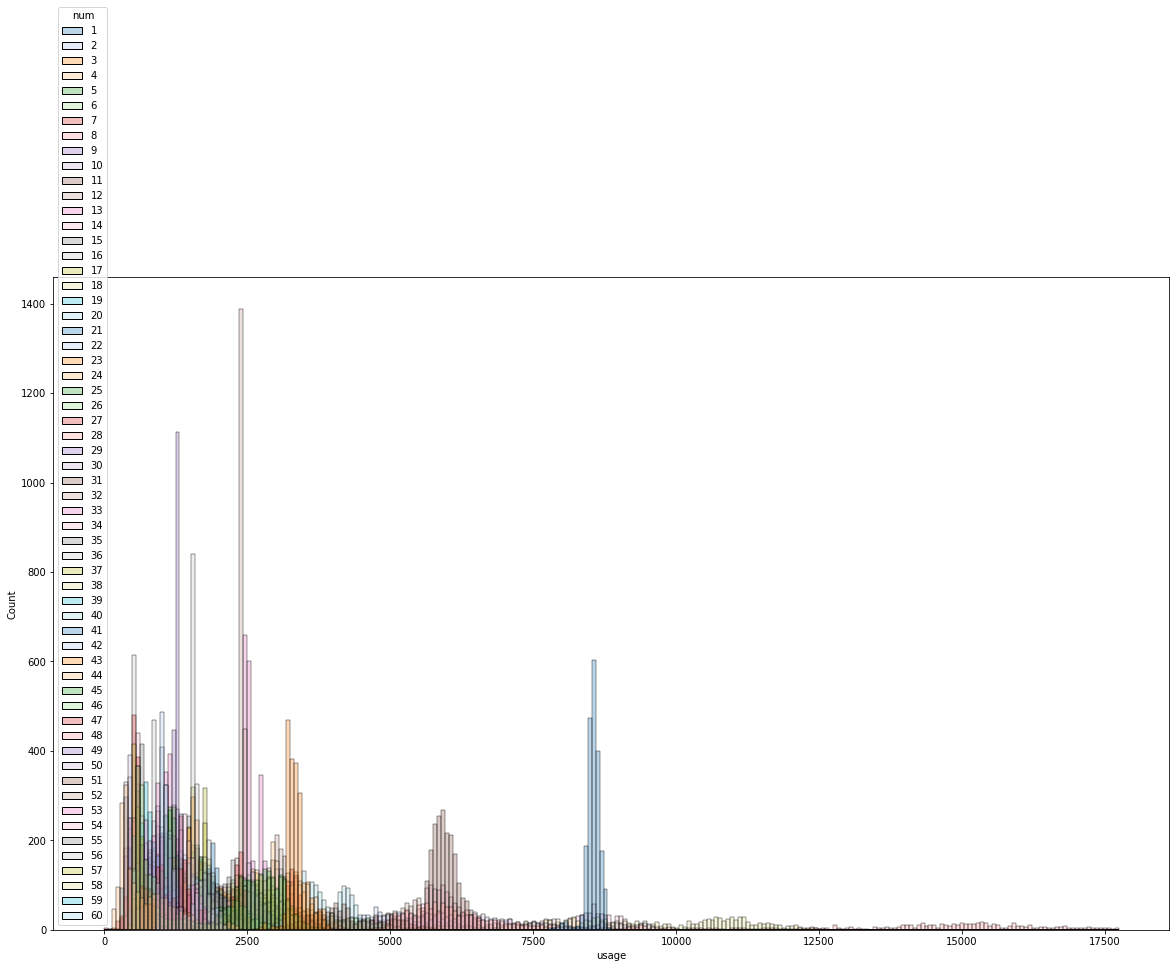

In [150]:
fig = plt.figure(figsize = (20, 12))
sns.histplot(data=eda, x='usage', hue = 'num', alpha = 0.3, palette = 'tab20')
plt.show()

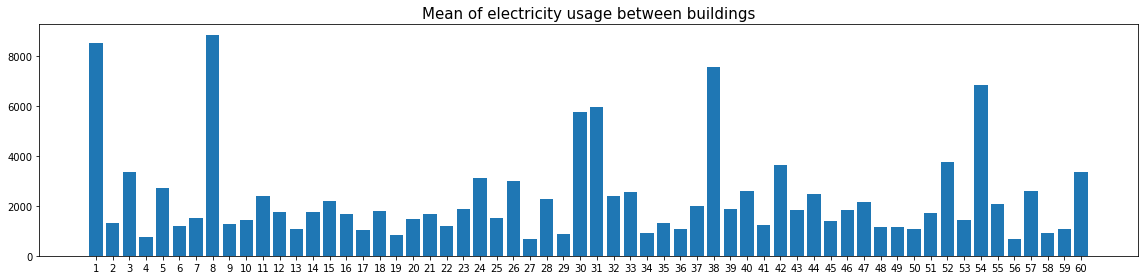

In [151]:
usage_summary = eda.pivot_table(values = 'usage', index = 'num', aggfunc = np.mean)  # index 항목별 values의 aggfunc을 계산(num 항목별 usage의 평균을 계산)

plt.figure(figsize = (16, 4))
plt.bar(usage_summary.index, usage_summary.usage)
plt.title('Mean of electricity usage between buildings', fontsize = 15)
plt.xticks(list(range(1,61)))
plt.tight_layout()
plt.show()

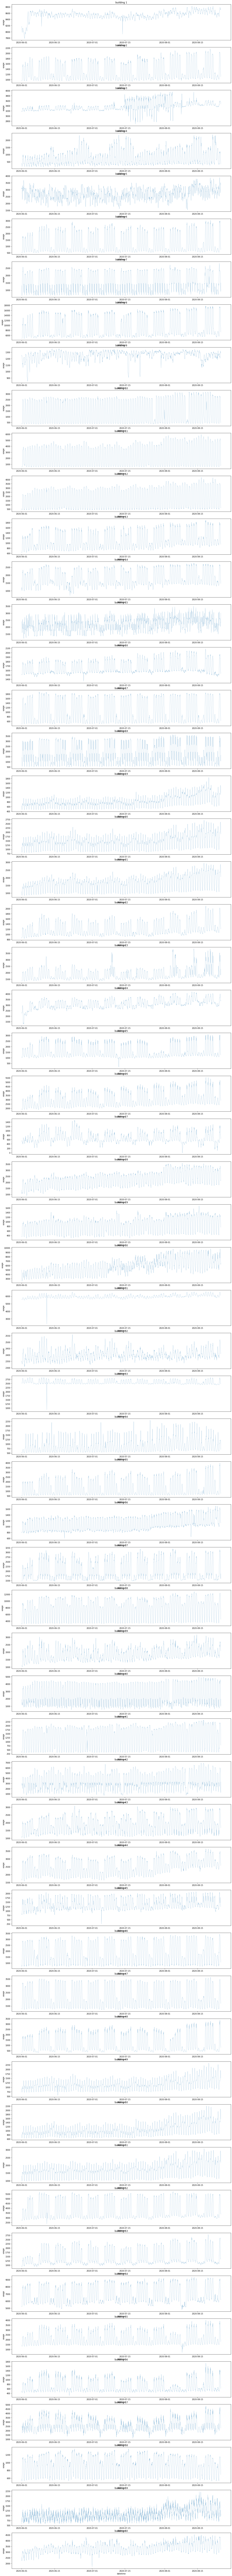

In [152]:
fig = plt.figure(figsize = (20, 240))
for i in eda['num'].unique():
    num_i = eda[eda.num == i]
    plt.subplot(60, 1, i)
    sns.lineplot(data = num_i, x = 'datetime', y = 'usage', linewidth = 0.3)
    plt.title(f'building {i}')

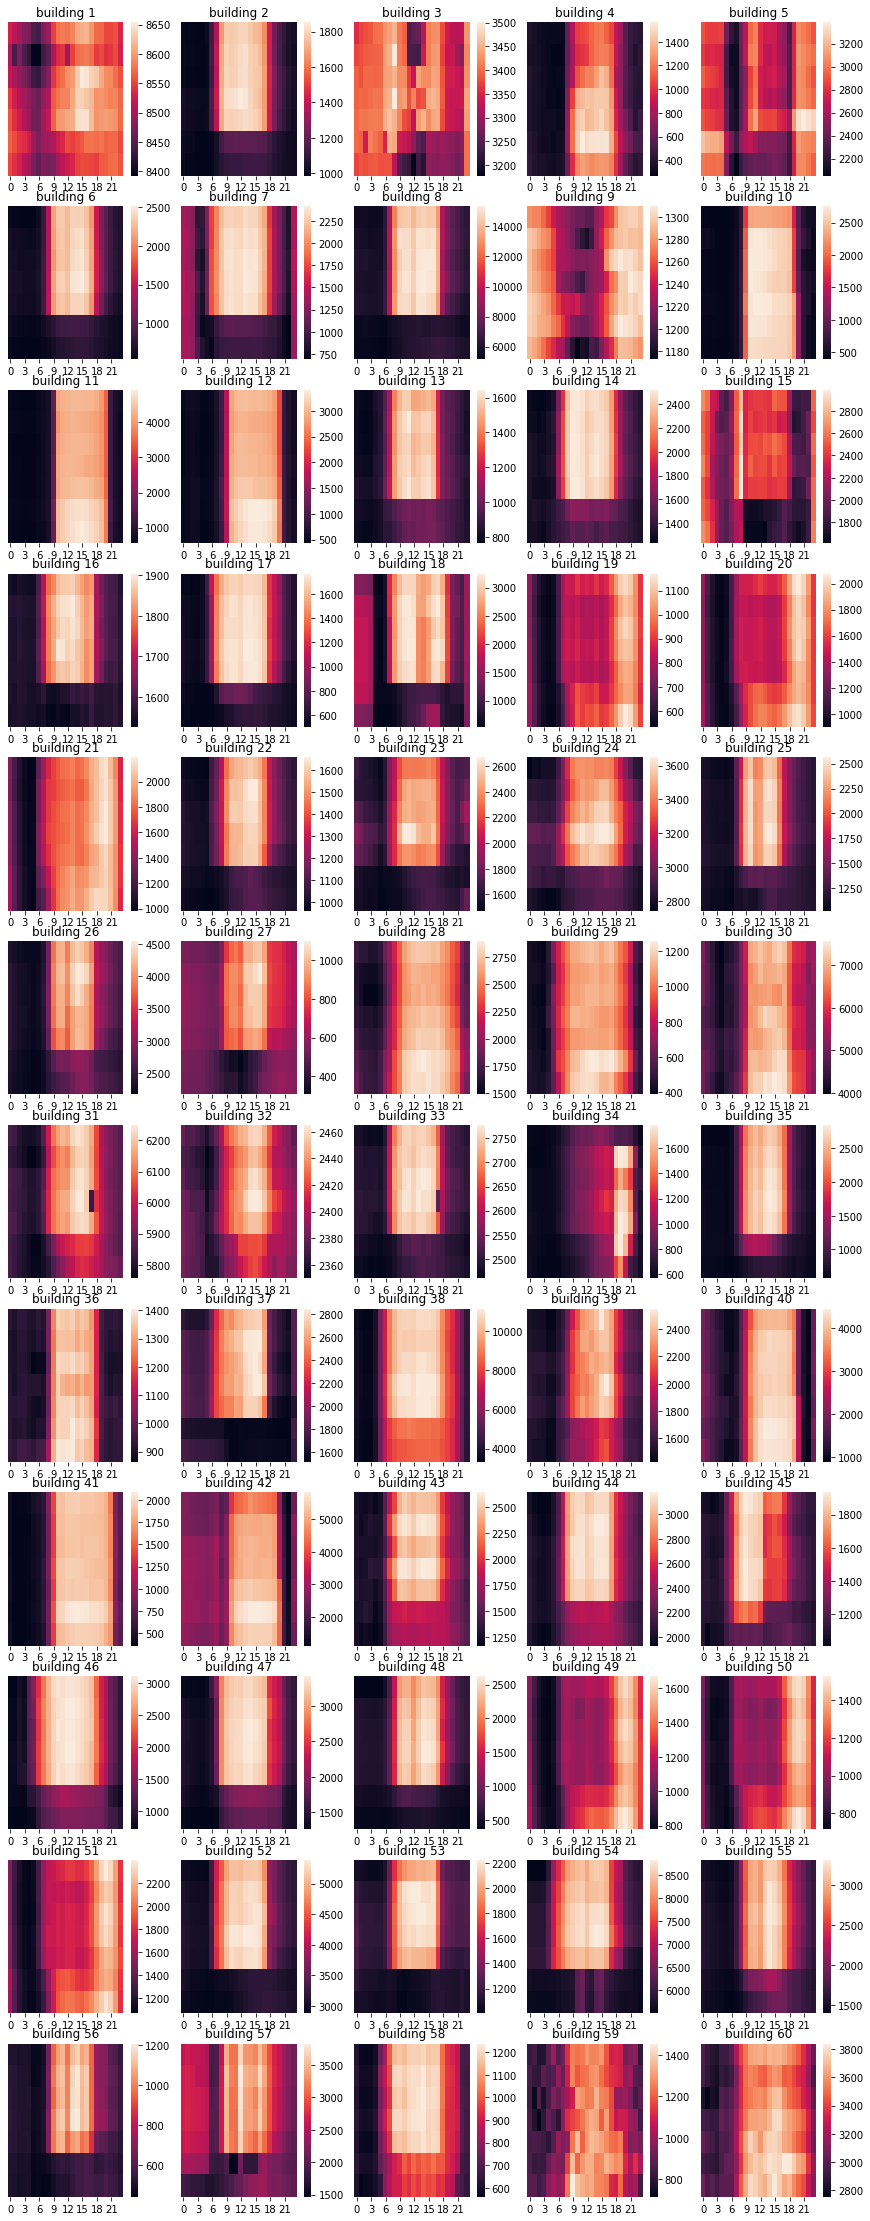

In [ ]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['usage'].mean().reset_index().pivot('weekday', 'hour', 'usage')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [156]:
num_10 = eda[eda.num == 10]
a = num_10[num_10.usage<=1000]
a[a.usage>=500][['date']].value_counts()

date      
2020-08-10    14
2020-07-27    12
2020-07-30     9
2020-07-24     7
2020-08-11     7
              ..
2020-06-28     2
2020-07-10     2
2020-07-03     2
2020-07-17     2
2020-06-06     1
Length: 85, dtype: int64

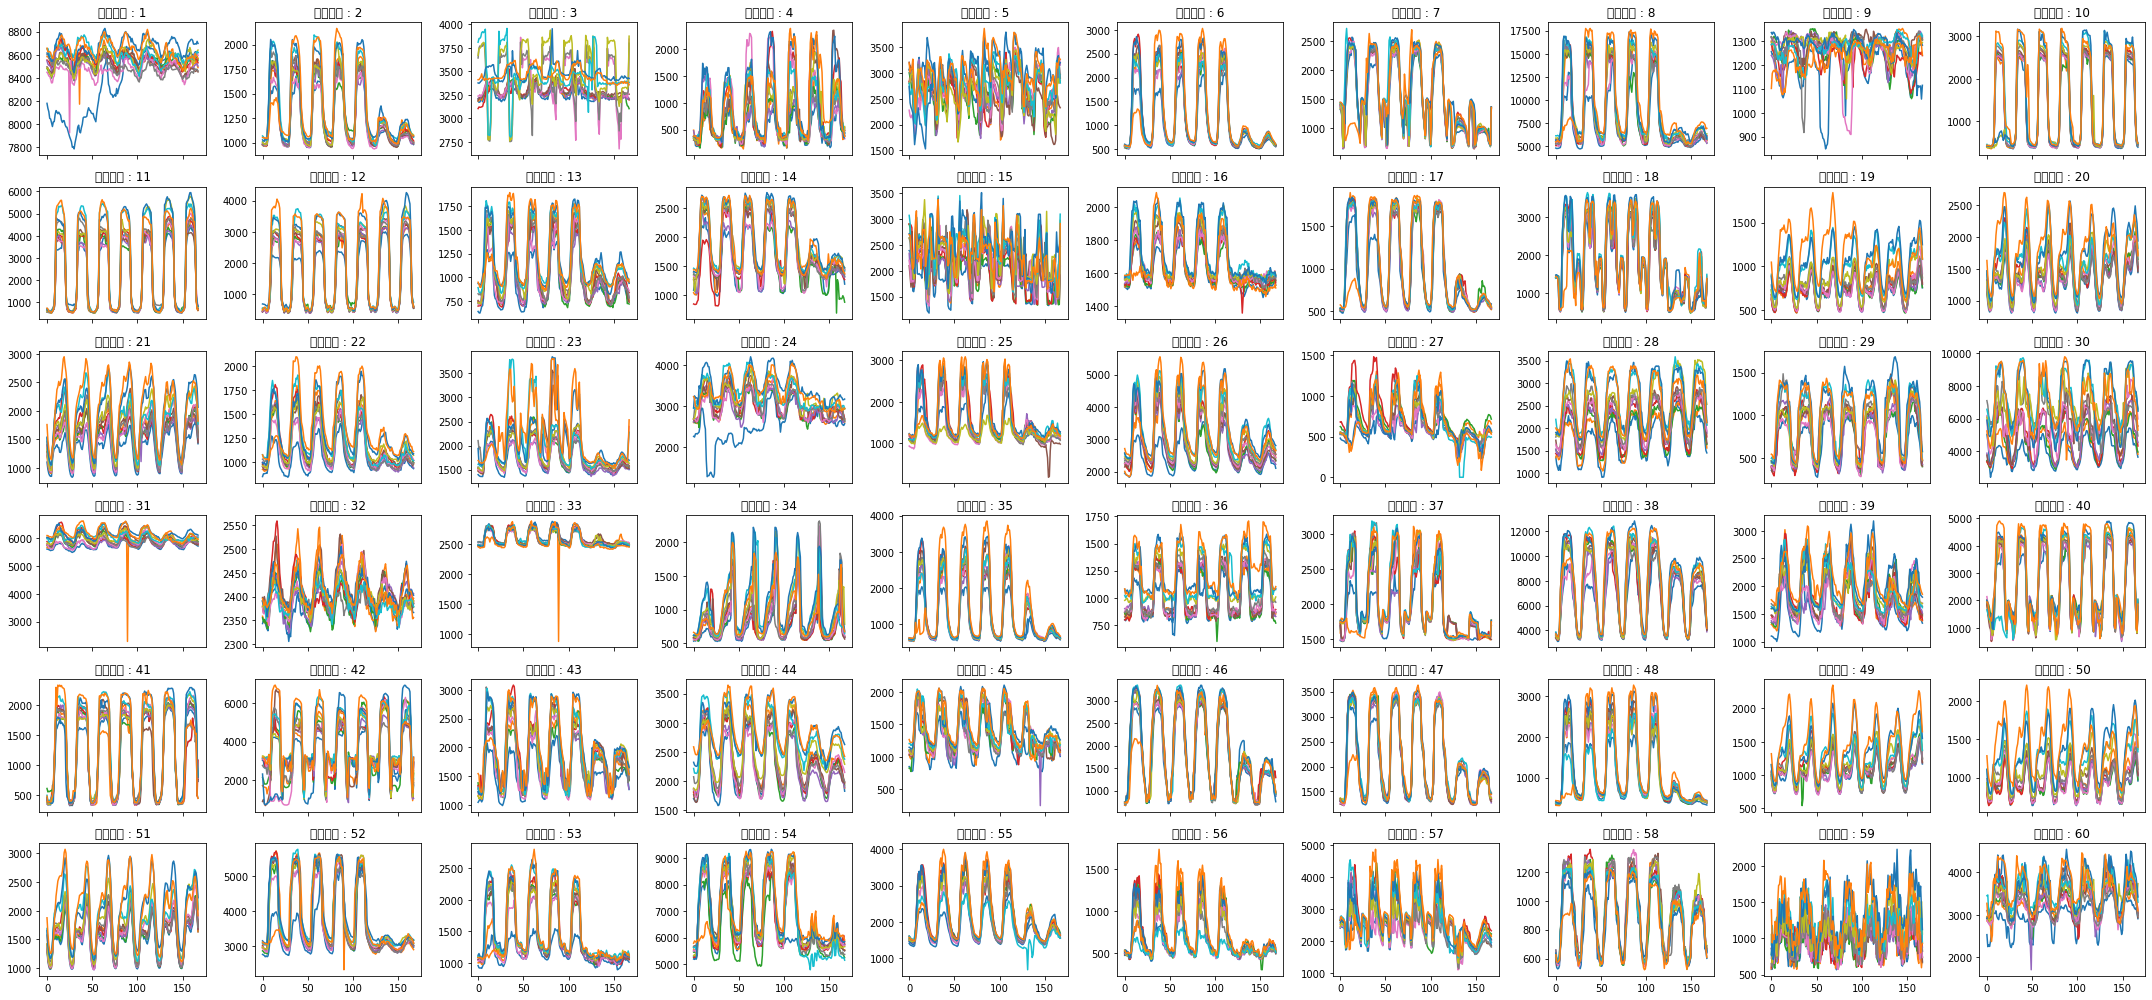

In [157]:
fig, axes = plt.subplots(6, 10, figsize = (30 ,14), sharex = True, sharey = False)
axes = axes.flatten()

for num, ax in zip(range(1, 61), axes):
    for i in range(1, 13):
        ax.plot(eda[eda['num'] == num]['usage'][24 * 7 * (i - 1):24 * 7 * i].values)
        ax.set_title(f'건물번호 : {num}')
plt.tight_layout()
plt.show()

In [158]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda.groupby(['num','weekday'])['usage'].median().reset_index().pivot('num','weekday','usage').reset_index()
by_hour = eda.groupby(['num','hour'])['usage'].median().reset_index().pivot('num','hour','usage').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [159]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

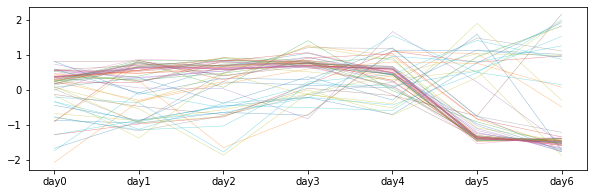

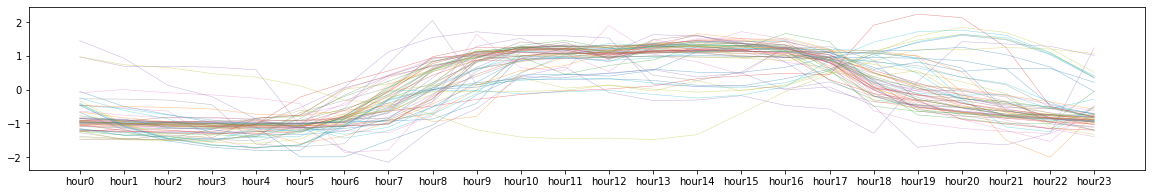

In [160]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

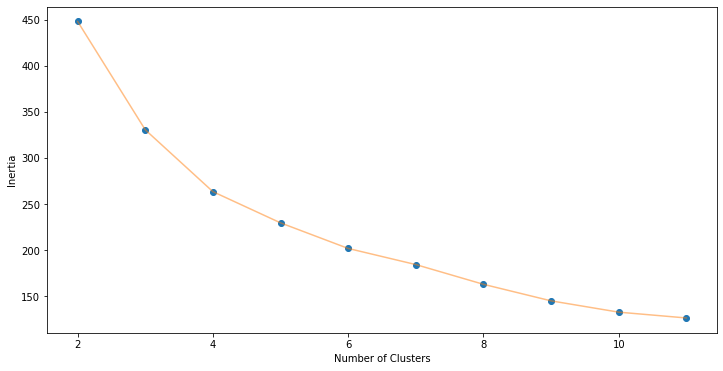

In [161]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [162]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [163]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

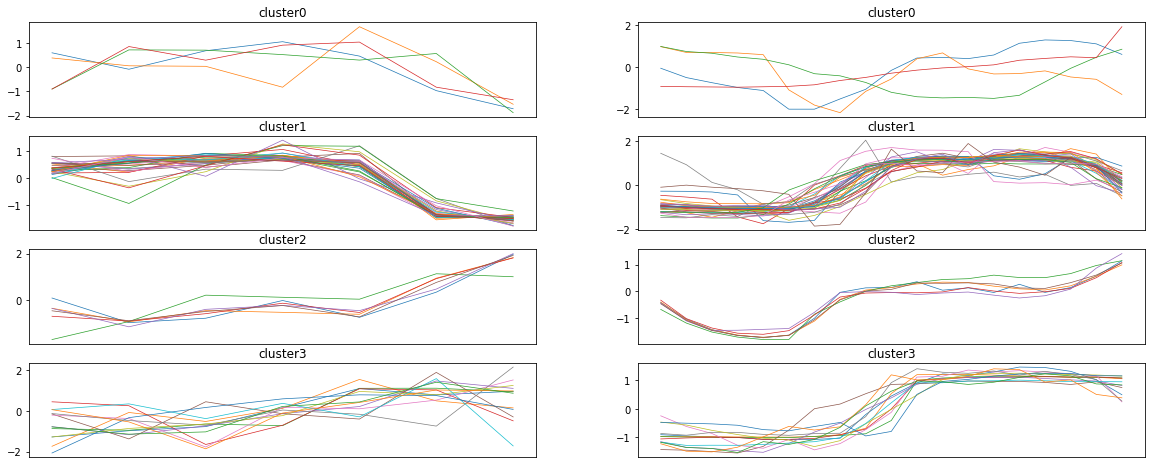

In [164]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [165]:
eda = eda.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

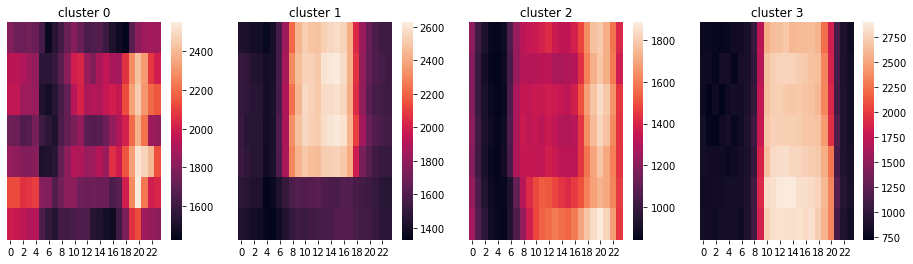

In [166]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda[eda.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['usage'].median().reset_index().pivot('weekday', 'hour', 'usage')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [167]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

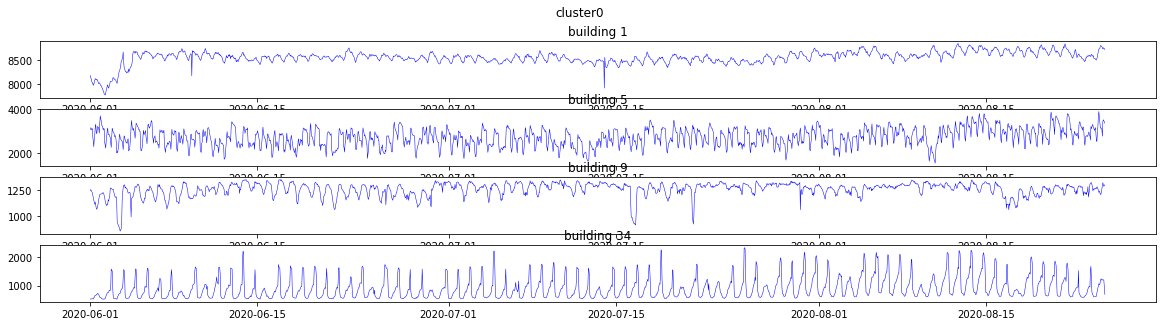

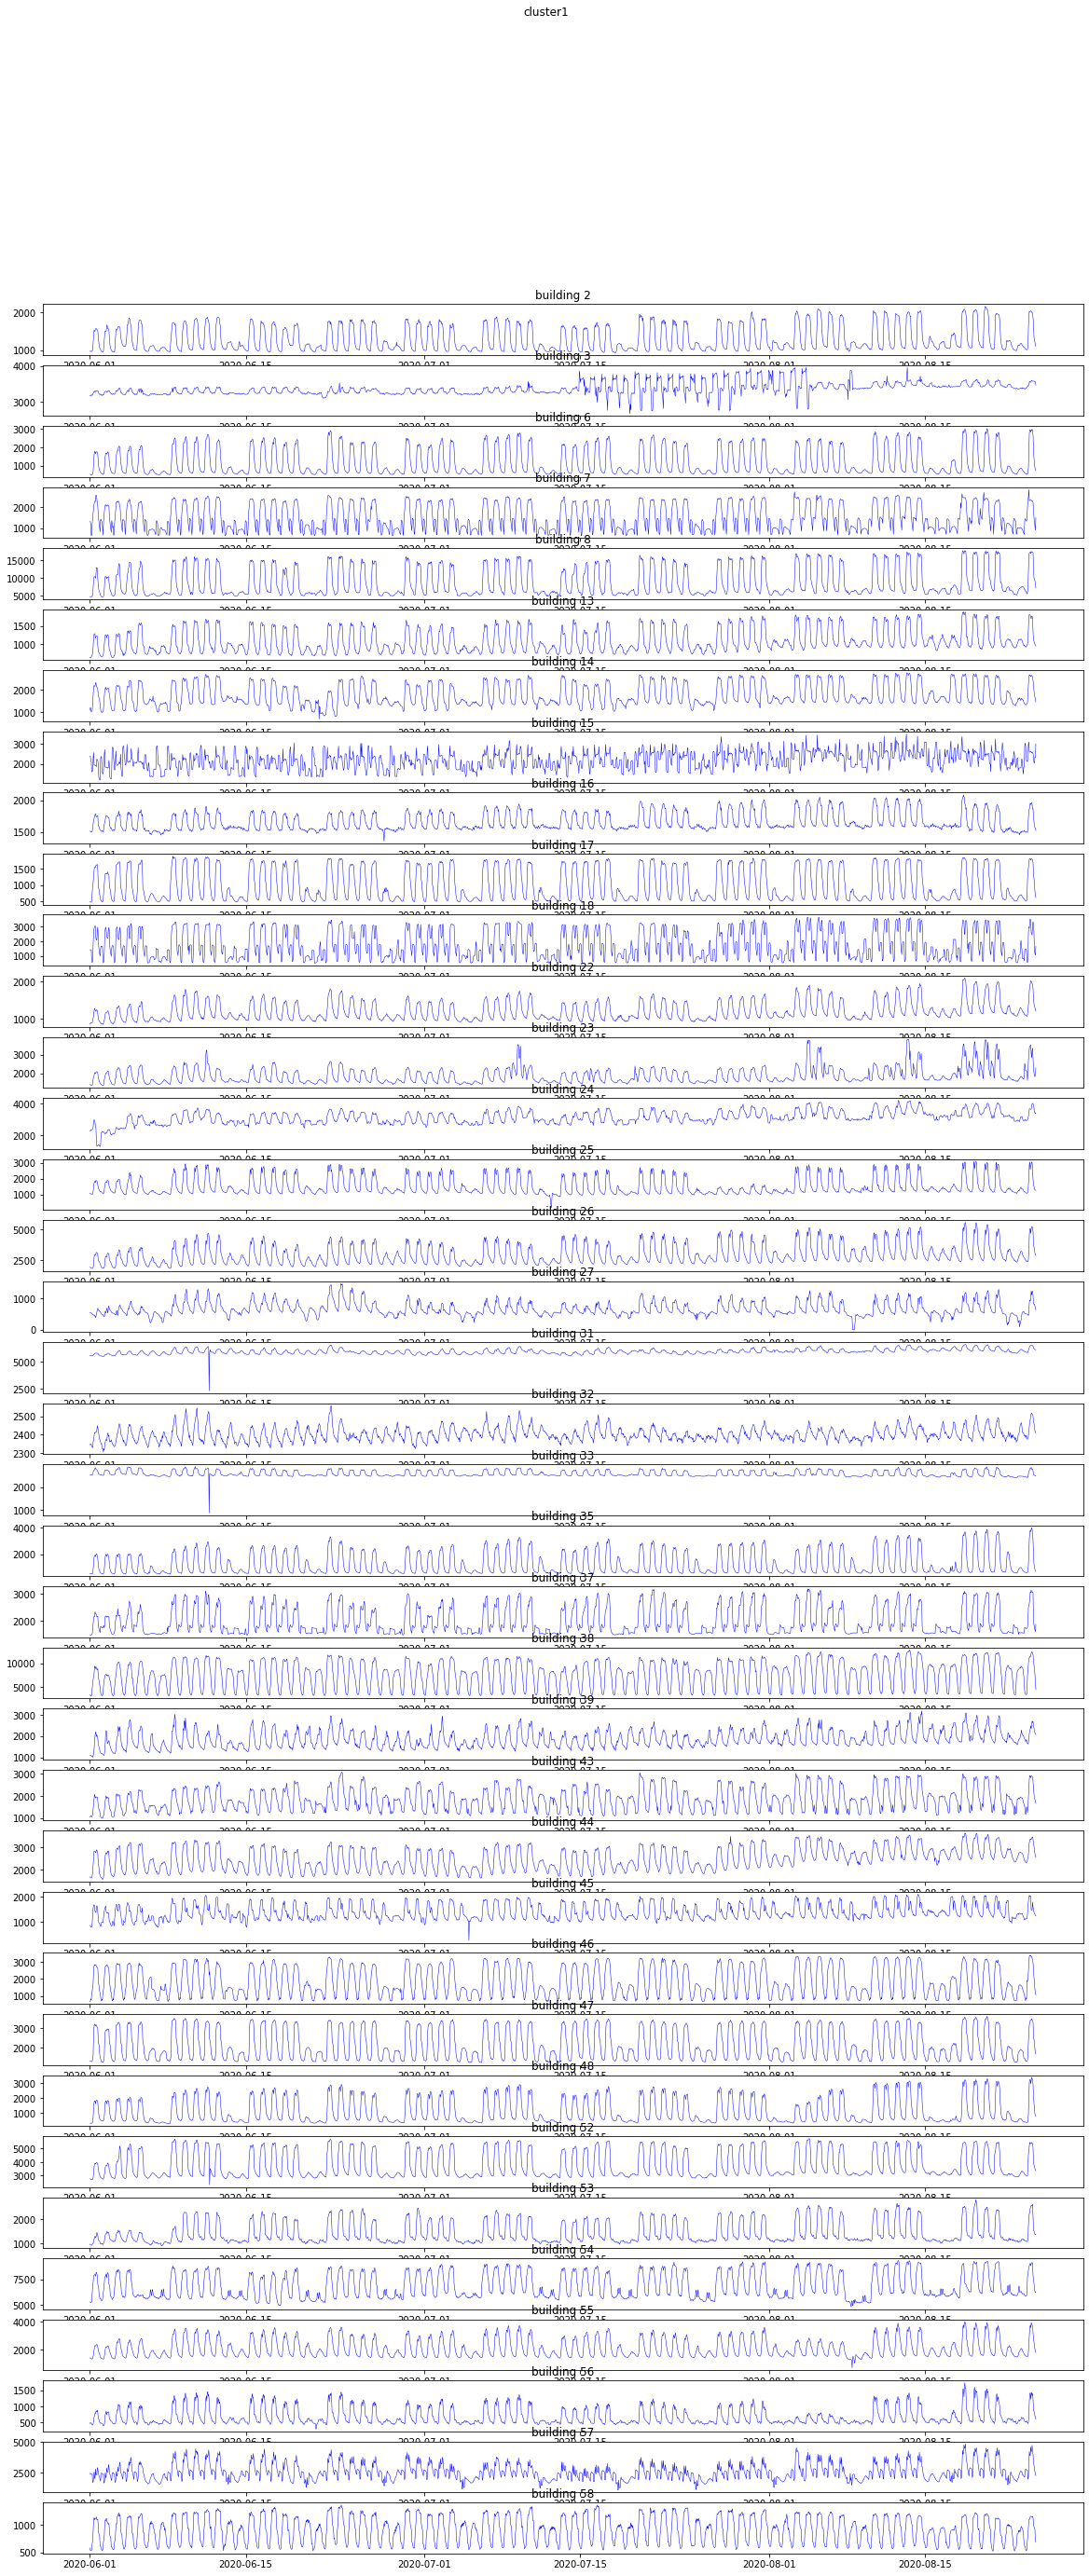

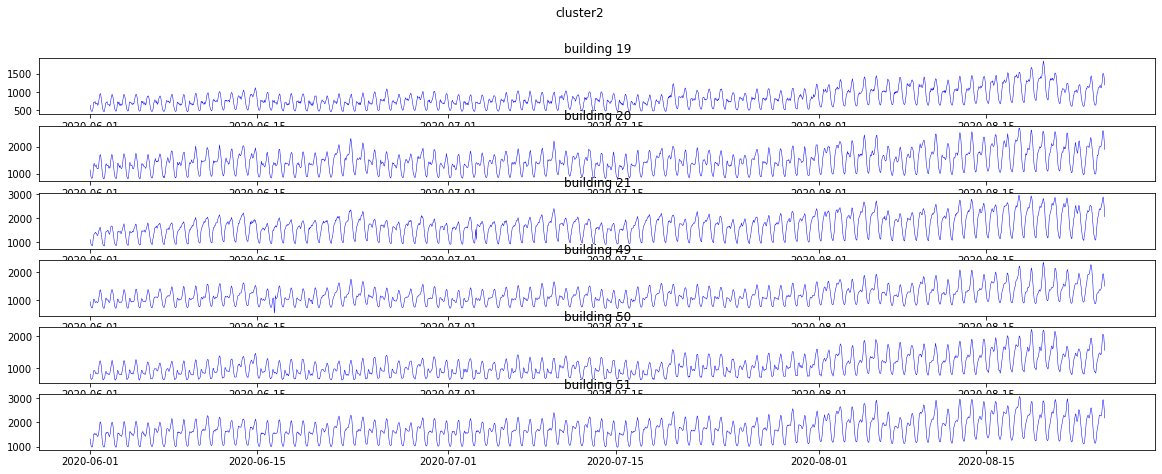

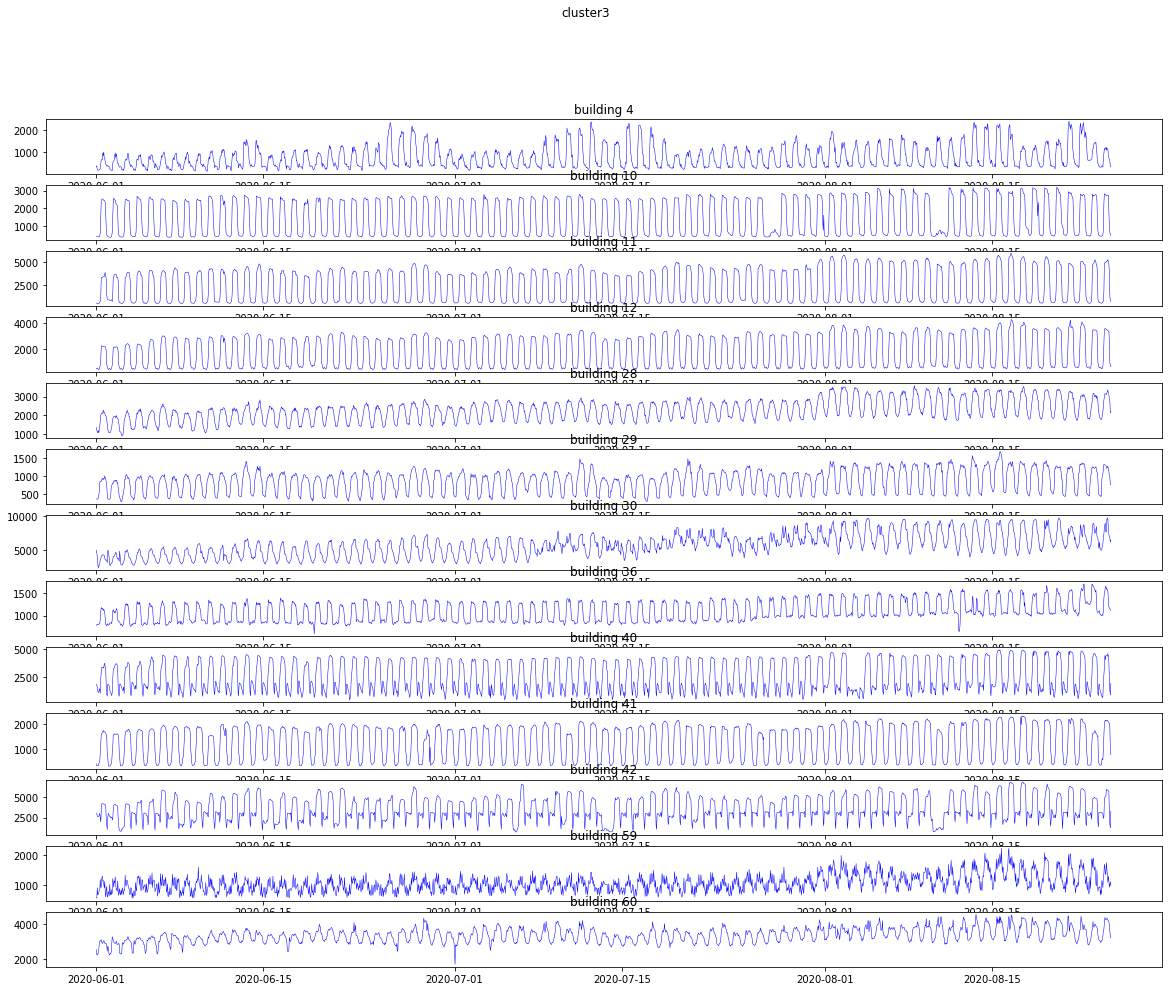

In [168]:
# linplot(energy usage of each building ~ cluster, datetime)
for c in range(4):
    temp_1 = eda[eda.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 1.2*n_nums))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'usage', linewidth = 0.5, color = 'blue')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

In [172]:
num_19 = eda[eda.num == 19]
building_1_corr = num_1.corr().iloc[1:7, 1:7]
building_1_corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

* 상관분석  
https://blog.naver.com/wtracer/221738979637

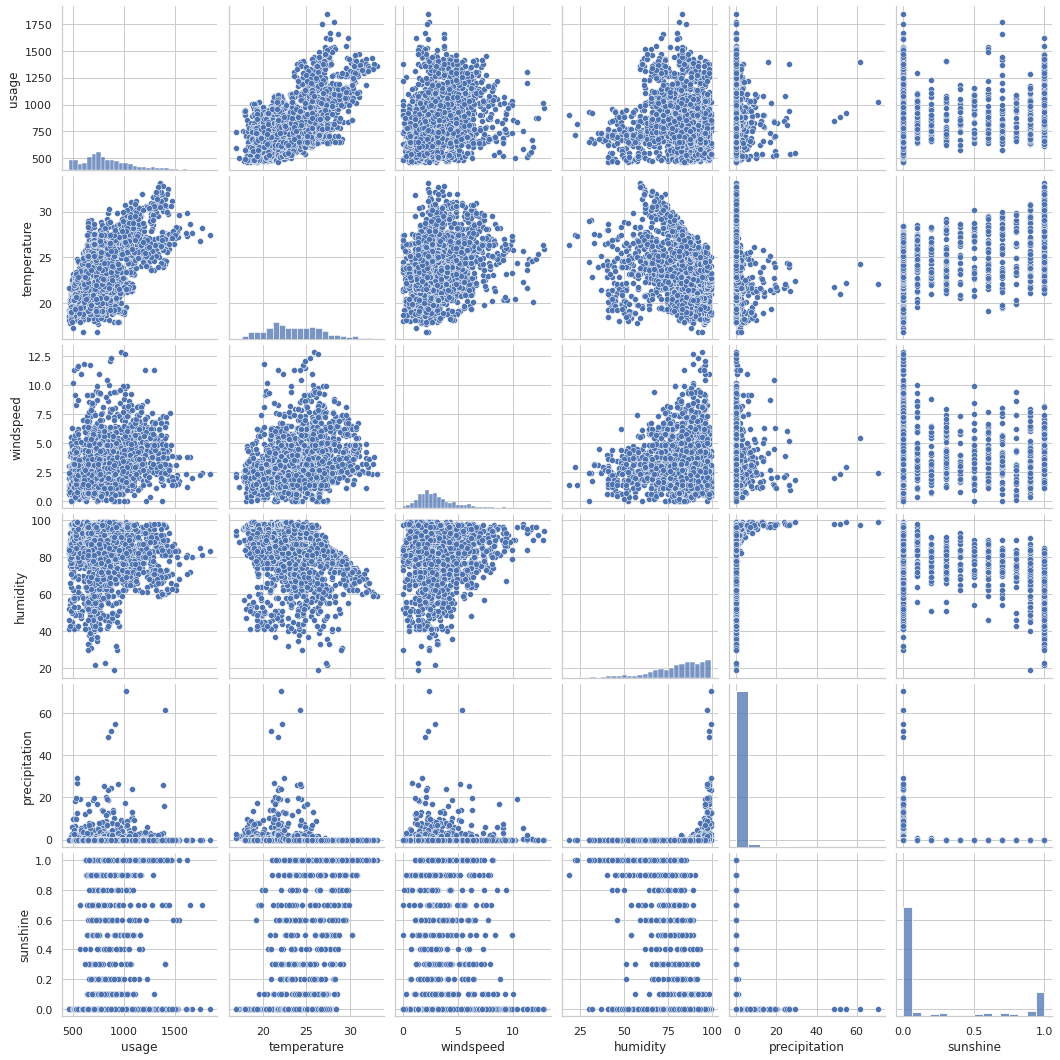

In [173]:
import seaborn as sns

sns.set(style = 'whitegrid', context = 'notebook')
sns.pairplot(num_19[['usage', 'temperature', 'windspeed', 'humidity', 'precipitation', 'sunshine']], height = 2.5)
plt.show()

* 상관분석 시각화  
https://blog.naver.com/sjy5448/222293781089

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', encoding='cp949')  # CSV파일에 한글로 된 내용이 있는 경우
test.head(15)

num      date_time  기온(°C)  ...  일조(hr, 3시간)  비전기냉방설비운영  태양광보유
0     1  2020-08-25 00    27.8  ...          0.0        NaN    NaN
1     1  2020-08-25 01     NaN  ...          NaN        NaN    NaN
2     1  2020-08-25 02     NaN  ...          NaN        NaN    NaN
3     1  2020-08-25 03    27.3  ...          0.0        NaN    NaN
4     1  2020-08-25 04     NaN  ...          NaN        NaN    NaN
5     1  2020-08-25 05     NaN  ...          NaN        NaN    NaN
6     1  2020-08-25 06    26.1  ...          0.0        NaN    NaN
7     1  2020-08-25 07     NaN  ...          NaN        NaN    NaN
8     1  2020-08-25 08     NaN  ...          NaN        NaN    NaN
9     1  2020-08-25 09    28.8  ...          1.1        NaN    NaN
10    1  2020-08-25 10     NaN  ...          NaN        NaN    NaN
11    1  2020-08-25 11     NaN  ...          NaN        NaN    NaN
12    1  2020-08-25 12    32.7  ...          3.0        NaN    NaN
13    1  2020-08-25 13     NaN  ...          NaN        NaN    NaN
14    1  2020-08-25 14     NaN  ...          NaN        NaN    NaN

[15 rows x 9 columns]

In [ ]:
test[['num']].value_counts()

num
60     168
59     168
28     168
27     168
26     168
25     168
24     168
23     168
22     168
21     168
20     168
19     168
18     168
17     168
16     168
15     168
14     168
13     168
12     168
11     168
10     168
9      168
8      168
7      168
6      168
5      168
4      168
3      168
2      168
29     168
30     168
31     168
46     168
58     168
57     168
56     168
55     168
54     168
53     168
52     168
51     168
50     168
49     168
48     168
47     168
45     168
32     168
44     168
43     168
42     168
41     168
40     168
39     168
38     168
37     168
36     168
35     168
34     168
33     168
1      168
dtype: int64

In [ ]:
test.info()  # test 데이터의 행과 열의 구성 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB
